# Variational Quantum Circuit
In this notebook we work to try and use Qiskit's [VQC class](https://qiskit.org/ecosystem/machine-learning/stubs/qiskit_machine_learning.algorithms.VQC.html) in order to make a circuit that can classify binary data.

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, ADAM, GradientDescent, P_BFGS, QNSPSA, SPSA
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import VQC
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 


from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import statistics

algorithm_globals.random_seed = 0
np.random.seed(0)

## Importing the data
In this notebook, we will use the following datasets:
 - [diabetes dataset](https://www.kaggle.com/datasets/mathchi/diabetes-data-set) which is a dataset containing 9 numeric features and a binary class
 - [iris dataset](https://www.kaggle.com/datasets/uciml/iris) which is a dataset containing 5 numeric features and 3 classes
 - [banknote dataset](https://machinelearningmastery.com/standard-machine-learning-datasets/) which is a dataset containing 4 numeric featues and a binary class

In [2]:
# Import the diabetes data
data = np.loadtxt('../datasets/diabetes.csv', delimiter=',', skiprows=1)
[n,p] = np.shape(data)

x = data[:, 0:-1]
y = data[:, -1]

# Only train on the 100 samples to start to speed up training
train_size = min(1, 100/n)

# Split data into training set and testing set
sample_train_diabetes, sample_test_diabetes, label_train_diabetes, label_test_diabetes = train_test_split(x, y,shuffle=True, train_size=train_size) 

# Normalize the data
sample_train_diabetes = normalize(sample_train_diabetes)
sample_test_diabetes = normalize(sample_test_diabetes)

In [21]:
# Import the iris data
data = np.loadtxt('../datasets/iris_data_numeric.txt', delimiter=',', skiprows=1)
[n,p] = np.shape(data)

x = data[:, 0:-1]
y = data[:, -1]

# Only train on the 100 samples to start to speed up training
train_size = min(1, 100/n)

# Split data into training set and testing set
sample_train_iris, sample_test_iris, label_train_iris, label_test_iris = train_test_split(x, y,shuffle=True, train_size=train_size) 

# Normalize the data
sample_train_iris = normalize(sample_train_iris)
sample_test_iris = normalize(sample_test_iris)

In [3]:
# Import the banknote data
data = np.loadtxt('../datasets/data_banknote_authentication.txt', delimiter=',', skiprows=1)
[n,p] = np.shape(data)

x = data[:, 0:-1]
y = data[:, -1]

# Only train on the 100 samples to start to speed up training
train_size = min(1, 100/n)

# Split data into training set and testing set
sample_train_banknote, sample_test_banknote, label_train_banknote, label_test_banknote = train_test_split(x, y,shuffle=True, train_size=train_size) 

# Normalize the data
sample_train_banknote = normalize(sample_train_banknote)
sample_test_banknote = normalize(sample_test_banknote)

## Creating artificial data
In addition to the real world data we have, we will also create 2 simple artificial data sets that will hopefully be easier to classify as a proof on concept.

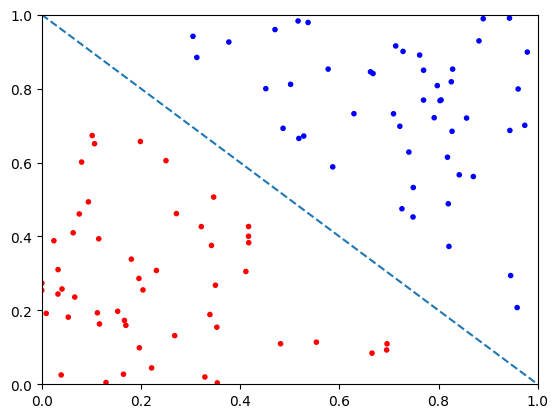

In [4]:
# Create a simple linear test dataset
num_train = 100
num_test = 100
lower_bound = 0
upper_bound = 1
min_dist = 0.1

# Define the function that determines the class
def f_linear(x):
    return -1*x + 1

def distance_to_line(x, y):
    return abs(x + y - 1)/np.sqrt(2)

def class_linear(x, y):
    if (y < f_linear(x)):
        return 0
    else:
        return 1

# Create the training and test set
sample_train_linear = np.random.rand(num_train, 2) * (upper_bound - lower_bound) + lower_bound
sample_test_linear = np.random.rand(num_test, 2) * (upper_bound - lower_bound) + lower_bound
label_train_linear = np.zeros(num_train)
label_test_linear = np.zeros(num_test)

# Force the training data to be a certain distance from the decision boundary
for i, point in enumerate(sample_train_linear):
    x = point[0]
    y = point[1]
    while (distance_to_line(x, y) < min_dist):
        x = np.random.rand()
        y = np.random.rand()
    sample_train_linear[i] = [x, y]

for i, point in enumerate(sample_test_linear):
    x = point[0]
    y = point[1]
    while (distance_to_line(x, y) < min_dist):
        x = np.random.rand()
        y = np.random.rand()
    sample_test_linear[i] = [x, y]

for i, x in enumerate(sample_train_linear):
    label_train_linear[i] = class_linear(x[0], x[1])

for i, x in enumerate(sample_test_linear):
    label_test_linear[i] = class_linear(x[0], x[1])

# Plot the dataset
plt.ylim(lower_bound, upper_bound)
plt.xlim(lower_bound, upper_bound)
color= ['red' if l == 0 else 'blue' for l in label_train_linear]
plt.scatter(sample_train_linear[:,0], sample_train_linear[:,1], color=color, marker='.')

# Plot the decision boundary
x = np.linspace(lower_bound, upper_bound, 100)
y = f_linear(x)
plt.plot(x, y, '--')

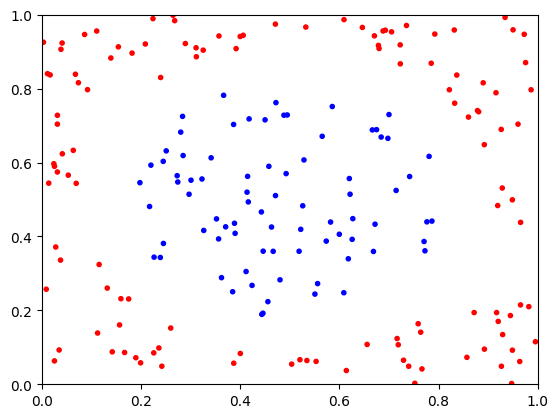

In [16]:
# Create a simple non-linear test dataset
num_train = 200
num_test = 100
lower_bound = 0
upper_bound = 1
data_radius = 0.1
boundary_width = 0.075

# Define the function that determines the class
def f_nonlinear(x, y):
    return (x-0.5)**2 + (y-0.5)**2

def class_nonlinear(x, y):
    if (f_nonlinear(x, y) > data_radius):
        return 0
    else:
        return 1

# Create the training and test set
sample_train_nonlinear = np.random.rand(num_train, 2) * (upper_bound - lower_bound) + lower_bound
sample_test_nonlinear = np.random.rand(num_test, 2) * (upper_bound - lower_bound) + lower_bound
label_train_nonlinear = np.zeros(num_train)
label_test_nonlinear = np.zeros(num_test)

# Create a gap between the train and test sets
for i, point in enumerate(sample_train_nonlinear):
    x = point[0]
    y = point[1]
    while(f_nonlinear(x, y) > data_radius and f_nonlinear(x, y) < data_radius + boundary_width):
        x = np.random.rand()
        y = np.random.rand()
    sample_train_nonlinear[i] = [x, y]

for i, point in enumerate(sample_test_nonlinear):
    x = point[0]
    y = point[1]
    while(f_nonlinear(x, y) > data_radius and f_nonlinear(x, y) < data_radius + boundary_width):
        x = np.random.rand()
        y = np.random.rand()
    sample_test_nonlinear[i] = [x, y]

# Create the labels as one hot encoded arrays
for i, x in enumerate(sample_train_nonlinear):
    label_train_nonlinear[i] = class_nonlinear(x[0], x[1])
for i, x in enumerate(sample_test_nonlinear):
    label_test_nonlinear[i] = class_nonlinear(x[0], x[1])

# Plot the dataset
plt.ylim(lower_bound, upper_bound)
plt.xlim(lower_bound, upper_bound)
color= ['red' if l == 0 else 'blue' for l in label_train_nonlinear]
plt.scatter(sample_train_nonlinear[:,0], sample_train_nonlinear[:,1], color=color, marker='.')

## Create the Variational Circuit
For our inital circuit, we will use cnot gates as out entangling layer, and we will start with just rz gates. We will have a cnot gate connect between every adjacent gate similar to one of the examples of entangling layers given in [this paper](https://arxiv.org/abs/2206.02806)

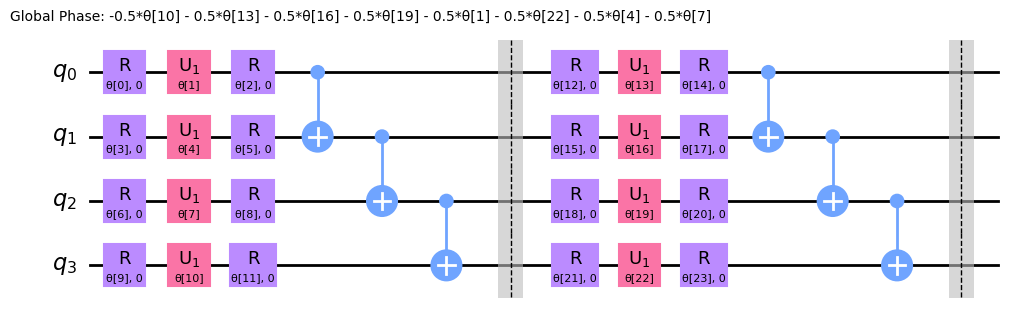

In [17]:
# Create a function so we can easily create new circuits
def cnot_rxzx_circuit(num_inputs, num_layers):
    num_parameters = num_inputs * num_layers * 3
    x = ParameterVector("θ", length=num_parameters)
    circuit = QuantumCircuit(num_inputs)
    
    #Create the processing blocks
    for layer in range(num_layers):
        #Create the parameterized gates
        for i in range(num_inputs):
            circuit.rx(x[layer*num_inputs*3 + 3*i], i)
            circuit.rz(x[layer*num_inputs*3 + 3*i + 1], i)
            circuit.rx(x[layer*num_inputs*3 + 3*i + 2], i)
        #Create the entangling layer
        for i in range(num_inputs - 1):
            circuit.cx(i,i+1)
        circuit.barrier()
        
    return circuit

# Draw an example of the ciruit
circuit = cnot_rxzx_circuit(4, 2)
circuit.decompose().draw('mpl')

## Train on Linear Dataset
Here we actually train the circuit. To start we will just use the ZZfeature map and the [COBYLA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.COBYLA.html) optimizer (Constrained Optimization By Linear Approximation opimizer). We can later vary these to see how they impact the training. 

### Classical model
We will train a classical neural network on the dataset initially so that we can later compare the performance to the quantum system

In [29]:
# train model and use it to make prediction
model = MLPClassifier(hidden_layer_sizes=(10), max_iter=1000, learning_rate_init=0.01)
model.fit(sample_train_linear, label_train_linear)
label_train_pred = model.predict(sample_train_linear)
label_test_pred = model.predict(sample_test_linear)

# evaluate model error
error_train = 1 - accuracy_score(label_train_linear, label_train_pred)
error_test = 1 - accuracy_score(label_test_linear, label_test_pred)

# print results
print("Training Error = %.4f" % error_train)
print('Testing Error = %.4f' % error_test)

Training Error = 0.0000
Testing Error = 0.0000


### Train and vary number of layers
In this section, we will now train the system 

In [30]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

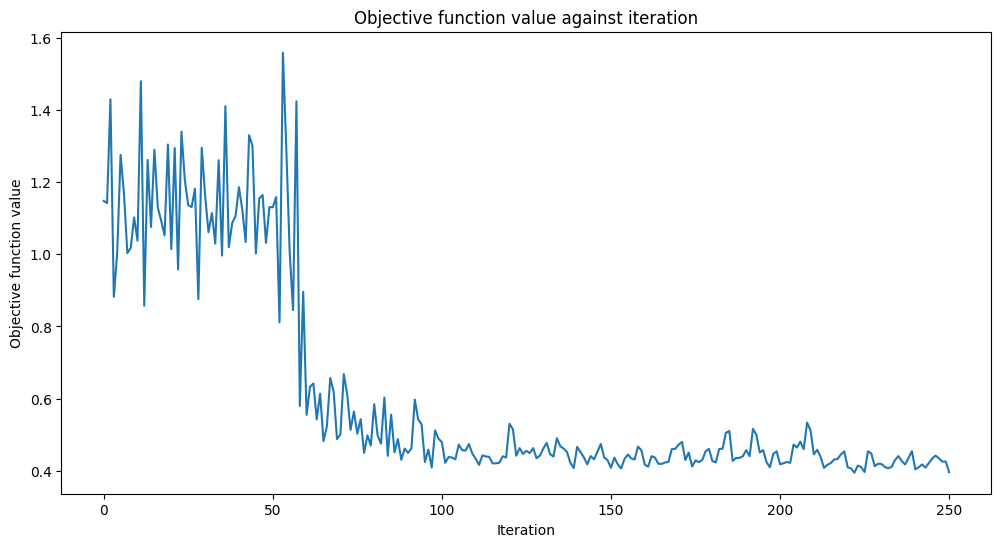

In [9]:
# Set the data set
x_train = sample_train_linear
y_train = label_train_linear
x_test = sample_test_linear
y_test = label_test_linear
num_inputs = len(x_train[0])

# construct feature map, ansatz, and optimizer
num_layers = 3
feature_map = ZZFeatureMap(num_inputs)
ansatz = cnot_rxzx_circuit(num_inputs, num_layers)
initial_point = np.random.rand(3*num_inputs*num_layers)

# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer= SPSA(maxiter=100),
    callback=callback_graph,
    initial_point=initial_point
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(x_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

## Evaluate the model
Here we see how accurately the model manages to predict both the training and test set. These values should be close to each other, or else we may have overfitting. 

In [10]:
# score classifier
training_error = 1 - vqc.score(x_train, y_train)
testing_error = 1 - vqc.score(x_test, y_test)
print(f"training error: {training_error:.3f}, testing error: {testing_error:.3f}")

training error: 0.040, testing error: 0.020


## Look at the predictions

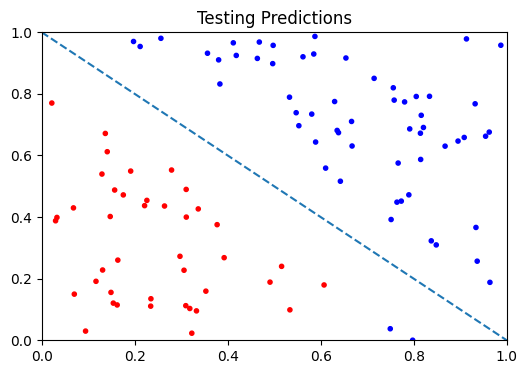

In [11]:
predictions = vqc.predict(x_test)

# Plot the predicitons vs the actual
plt.title("Testing Predictions")
plt.ylim(lower_bound, upper_bound)
plt.xlim(lower_bound, upper_bound)
color= ['red' if l == 0 else 'blue' for l in predictions]
plt.scatter(x_test[:,0], x_test[:,1], color=color, marker='.')

# Plot the decision boundary
x = np.linspace(lower_bound, upper_bound, 100)
y = f_linear(x)
plt.plot(x, y, '--')

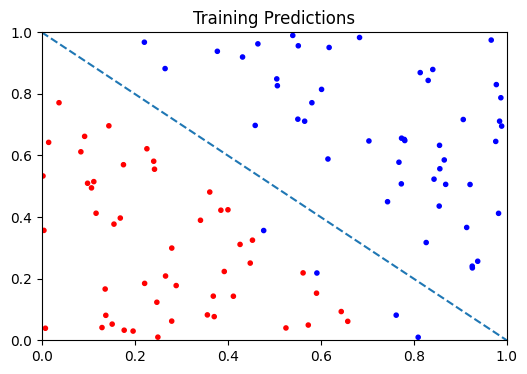

In [12]:
predictions = vqc.predict(x_train)

# Plot the predicitons vs the actual
plt.title("Training Predictions")
plt.ylim(lower_bound, upper_bound)
plt.xlim(lower_bound, upper_bound)
color= ['red' if l == 0 else 'blue' for l in predictions]
plt.scatter(x_train[:,0], x_train[:,1], color=color, marker='.')

# Plot the decision boundary
x = np.linspace(lower_bound, upper_bound, 100)
y = f_linear(x)
plt.plot(x, y, '--')

## Train on nonlinear dataset

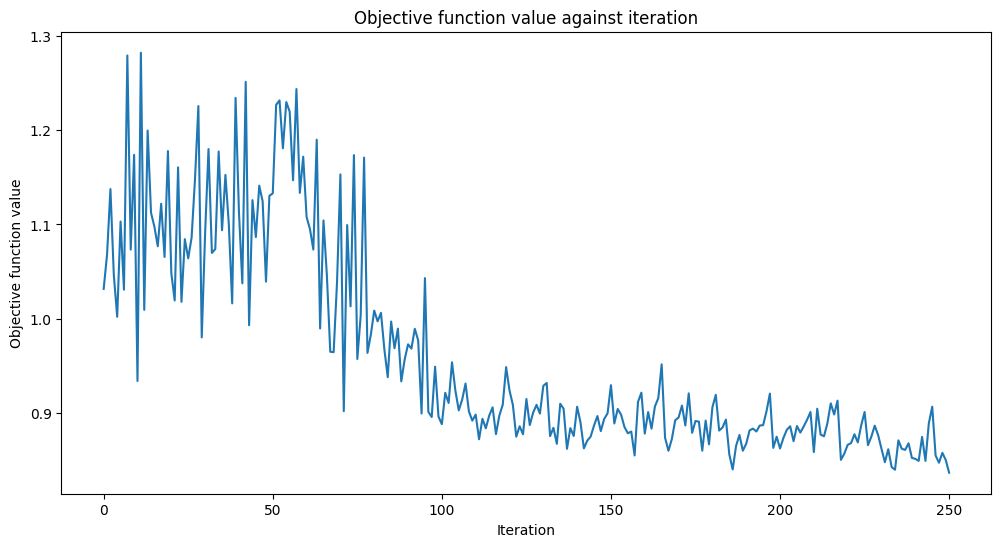

In [13]:
# Set the data set
x_train = sample_train_nonlinear
y_train = label_train_nonlinear
x_test = sample_test_nonlinear
y_test = label_test_nonlinear
num_inputs = len(x_train[0])

# construct feature map, ansatz, and optimizer
num_layers = 3
feature_map = ZZFeatureMap(num_inputs)
ansatz = cnot_rxzx_circuit(num_inputs, num_layers)
initial_point = np.random.rand(3*num_inputs*num_layers)

# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer= SPSA(maxiter=100),
    callback=callback_graph,
    initial_point=initial_point
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(x_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

## Evaluate the model

In [14]:
# score classifier
training_error = 1 - vqc.score(x_train, y_train)
testing_error = 1 - vqc.score(x_test, y_test)
print(f"training error: {training_error:.3f}, testing error: {testing_error:.3f}")

training error: 0.380, testing error: 0.440


## Look at the predictions

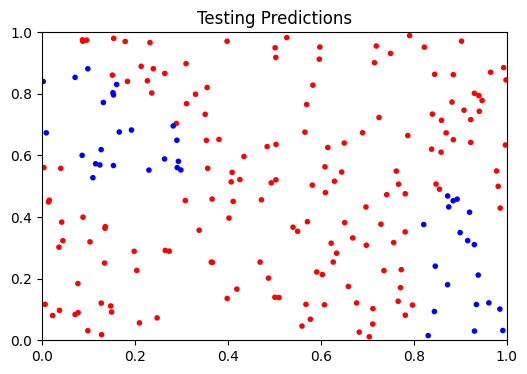

In [15]:
predictions = vqc.predict(x_test)

# Plot the predicitons vs the actual
plt.title("Testing Predictions")
plt.ylim(lower_bound, upper_bound)
plt.xlim(lower_bound, upper_bound)
color= ['red' if l == 0 else 'blue' for l in predictions]
plt.scatter(x_test[:,0], x_test[:,1], color=color, marker='.')

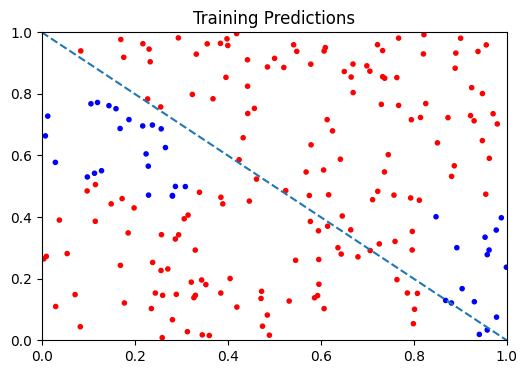

In [16]:
predictions = vqc.predict(x_train)

# Plot the predicitons vs the actual
plt.title("Training Predictions")
plt.ylim(lower_bound, upper_bound)
plt.xlim(lower_bound, upper_bound)
color= ['red' if l == 0 else 'blue' for l in predictions]
plt.scatter(x_train[:,0], x_train[:,1], color=color, marker='.')

# Plot the decision boundary
x = np.linspace(lower_bound, upper_bound, 100)
y = f_linear(x)
plt.plot(x, y, '--')

## Train on the iris dataset
This is a real world dataset with 3 classes, so we expect worse results than compared to the artificial datasets

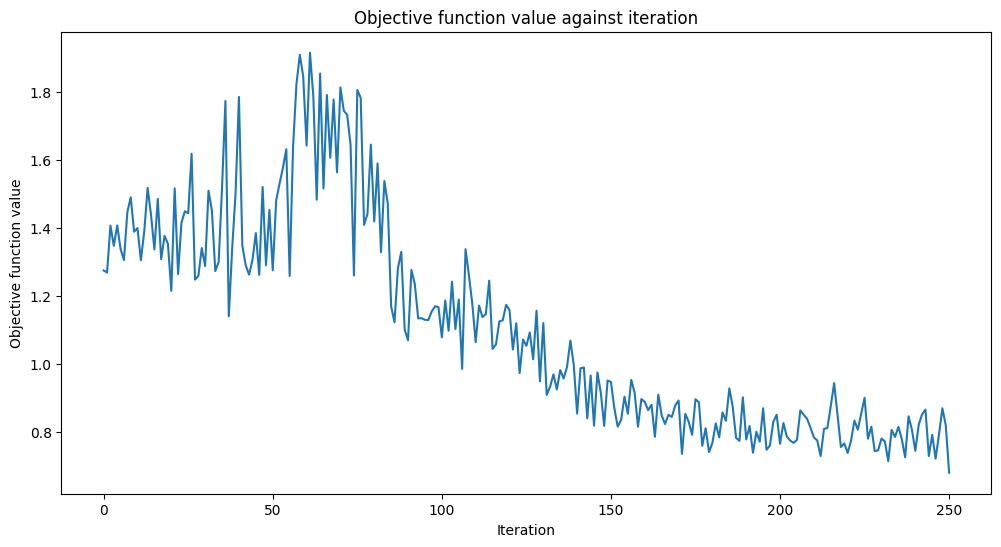

In [17]:
# Set the data set
x_train = sample_train_iris
y_train = label_train_iris
x_test = sample_test_iris
y_test = label_test_iris
num_inputs = len(x_train[0])

# construct feature map, ansatz, and optimizer
num_layers = 3
feature_map = ZZFeatureMap(num_inputs)
ansatz = cnot_rxzx_circuit(num_inputs, num_layers)
initial_point = np.random.rand(3*num_inputs*num_layers)

# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer= SPSA(maxiter=100),
    callback=callback_graph,
    initial_point=initial_point
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(x_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

## Evaluate the model

In [18]:
# score classifier
training_error = 1 - vqc.score(x_train, y_train)
testing_error = 1 - vqc.score(x_test, y_test)
print(f"training error: {training_error:.3f}, testing error: {testing_error:.3f}")

training error: 0.054, testing error: 0.000


## Train on the banknote dataset

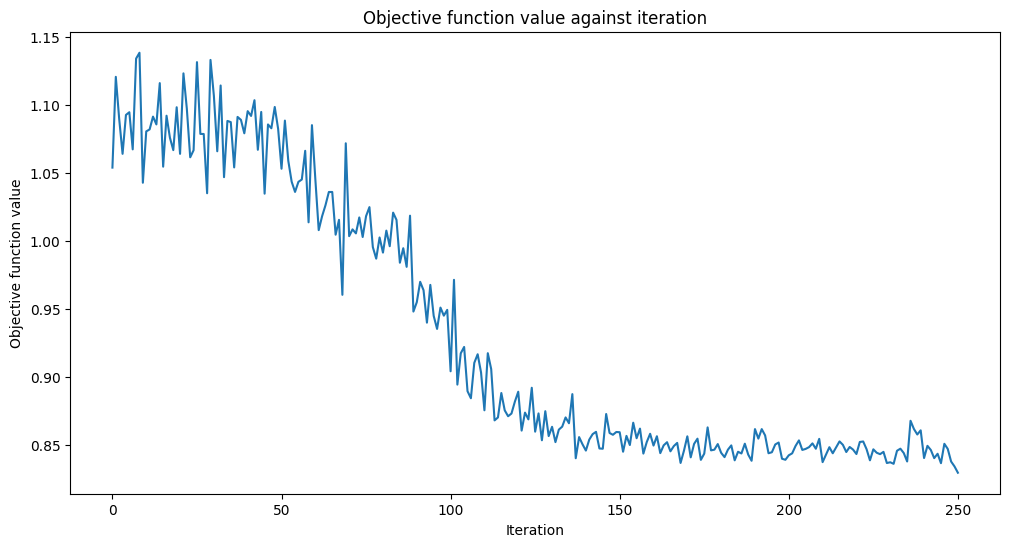

In [24]:
# Set the data set
x_train = sample_train_banknote
y_train = label_train_banknote
x_test = sample_test_banknote
y_test = label_test_banknote
num_inputs = len(x_train[0])

# construct feature map, ansatz, and optimizer
num_layers = 3
feature_map = ZZFeatureMap(num_inputs)
ansatz = cnot_rxzx_circuit(num_inputs, num_layers)
initial_point = np.random.rand(3*num_inputs*num_layers)

# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer= SPSA(maxiter=100),
    callback=callback_graph,
    initial_point=initial_point
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(x_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

## Evaluate the model

In [25]:
# score classifier
training_error = 1 - vqc.score(x_train, y_train)
testing_error = 1 - vqc.score(x_test, y_test)
print(f"training error: {training_error:.3f}, testing error: {testing_error:.3f}")

training error: 0.300, testing error: 0.420


## Train on the diabetes dataset

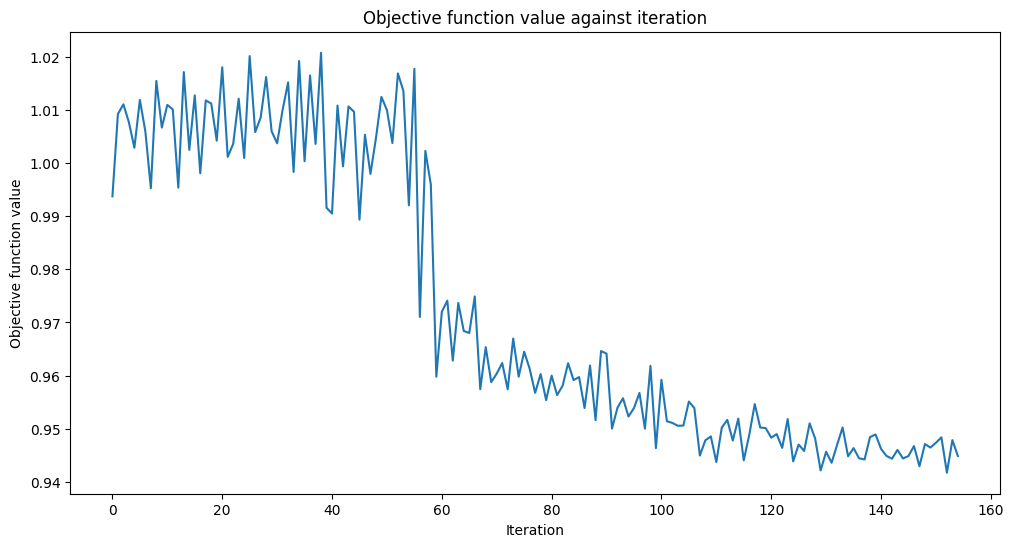

KeyboardInterrupt: 

In [28]:
# Set the data set
x_train = sample_train_diabetes
y_train = label_train_diabetes
x_test = sample_test_diabetes
y_test = label_test_diabetes
num_inputs = len(x_train[0])

# construct feature map, ansatz, and optimizer
num_layers = 3
feature_map = ZZFeatureMap(num_inputs)
ansatz = cnot_rxzx_circuit(num_inputs, num_layers)
initial_point = np.random.rand(3*num_inputs*num_layers)

# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer= SPSA(maxiter=100),
    callback=callback_graph,
    initial_point=initial_point
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(x_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

## Evaluate the model

In [ ]:
# score classifier
training_error = 1 - vqc.score(x_train, y_train)
testing_error = 1 - vqc.score(x_test, y_test)
print(f"training error: {training_error:.3f}, testing error: {testing_error:.3f}")

## Vary number of layers
Now that we have a baseline model, we can vary the number of layers to see how that impacts the accuracy of the system. A proper test would use k-fold cross validation, but for now we will just train 1 model for each on the same training data as a proof of concept.

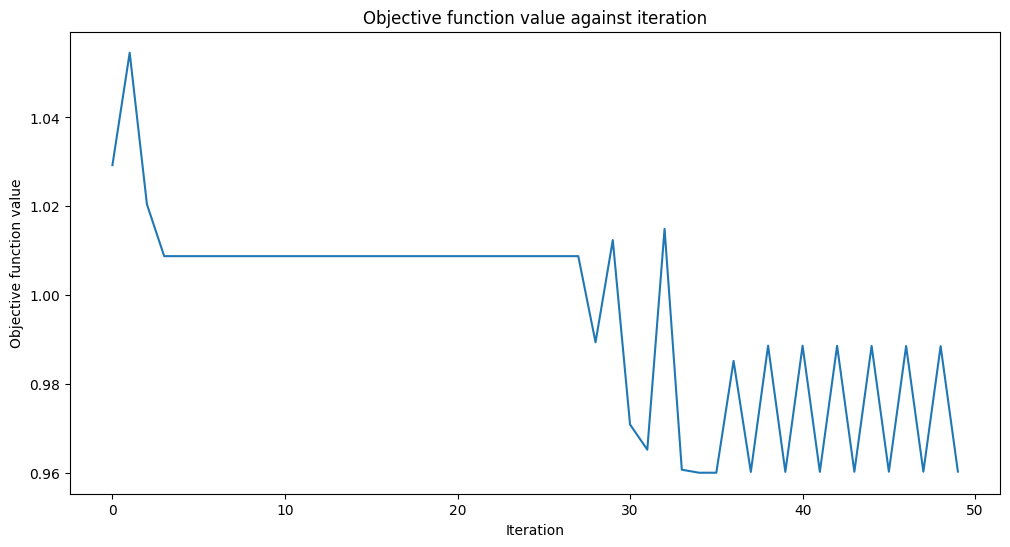

In [15]:
layers_to_test = [1, 2, 3, 4, 5]
training_errors = []
testing_errors = []

#Loop through and test different number of layers
for num_layers in layers_to_test:
    # construct feature map, ansatz, and optimizer
    num_layers = 1
    feature_map = ZZFeatureMap(num_inputs)
    ansatz = cnot_rxzx_circuit(num_inputs, num_layers=num_layers)
    initial_point = np.random.rand(num_inputs*num_layers*3)
    
    # construct variational quantum classifier
    vqc = VQC(
        feature_map=feature_map,
        warm_start=True,
        ansatz=ansatz,
        loss="cross_entropy",
        optimizer=COBYLA(maxiter=50),
        callback=callback_graph,
        initial_point=initial_point
    )

    # create empty array for callback to store evaluations of the objective function
    objective_func_vals = []
    plt.rcParams["figure.figsize"] = (12, 6)
    
    # fit classifier to data
    vqc.fit(sample_train, label_train_one_hot)
    
    # return to default figsize
    plt.rcParams["figure.figsize"] = (6, 4)

    # Evaluate the model
    training_error = 1 - vqc.score(sample_train, label_train_one_hot)
    testing_error = 1 - vqc.score(sample_test, label_test_one_hot)
    training_errors.append(training_error)
    testing_errors.append(testing_error)

### Plot the results
Now that we have trained models with several different numbers of layers, we can plot the results to see how the number of layers impacts the model accuracy

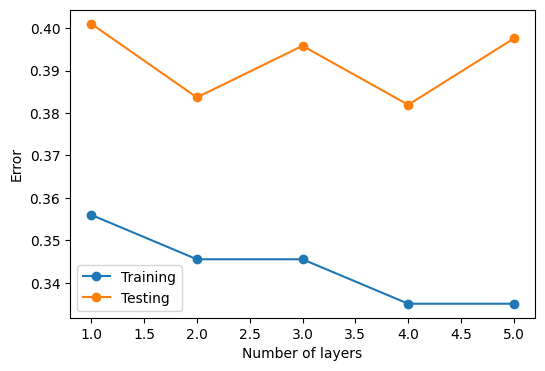

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_xlabel("Number of layers")
ax.set_ylabel("Error")
ax.plot(layers_to_test, training_errors, marker='o', label="Training")
ax.plot(layers_to_test, testing_errors, marker='o', label="Testing")
ax.legend()

### Comments
Here is seems as if training error consistently dropped with the number of layers, but the testing error did not see much improvement, likely implying that larger models tended to overfit the data. Watching the objective function vs training iteration, it also seems as if the smaller models converged by 50 iterations, but the larger models could need more training time since they have a greater number of parameters. In classical machine learning, there is a way to halt training after a certain number of iterations of no improvement, so that might be worth looking into to see if such a method exists for VQC or if I will have to implement it manually. The paper I'm aiming to reproduce also collected data up to a depth of 12 layer, but they saw very marginal changes after the first few layers. I will have to test to see if the same is true when I increase the depth.

## Try double CNOT entanglement layer
Here we will perform the test where we vary the number of layers, but this time we will use a double layer of CNOT gates to increase the level of entanglement to see how that impacts the performance of the classifier.

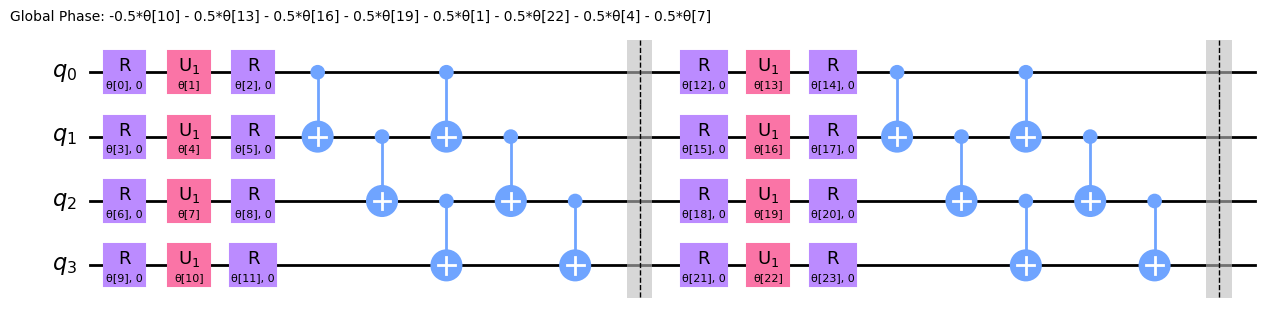

In [18]:
# Create a function so we can easily create new circuits
def double_cnot_rxzx_circuit(num_inputs, num_layers):
    num_parameters = num_inputs * num_layers * 3
    x = ParameterVector("θ", length=num_parameters)
    circuit = QuantumCircuit(num_inputs)
    
    #Create the processing blocks
    for layer in range(num_layers):
        #Create the parameterized gates
        for i in range(num_inputs):
            circuit.rx(x[layer*num_inputs*3 + 3*i], i)
            circuit.rz(x[layer*num_inputs*3 + 3*i + 1], i)
            circuit.rx(x[layer*num_inputs*3 + 3*i + 2], i)
        #Create the entangling layer
        for i in range(num_inputs - 1):
            circuit.cx(i,i+1)
        for i in range(num_inputs - 1):
            circuit.cx(i,i+1)
        circuit.barrier()
        
    return circuit

# Draw an example of the ciruit
circuit = double_cnot_rxzx_circuit(4, 2)
circuit.decompose().draw('mpl')

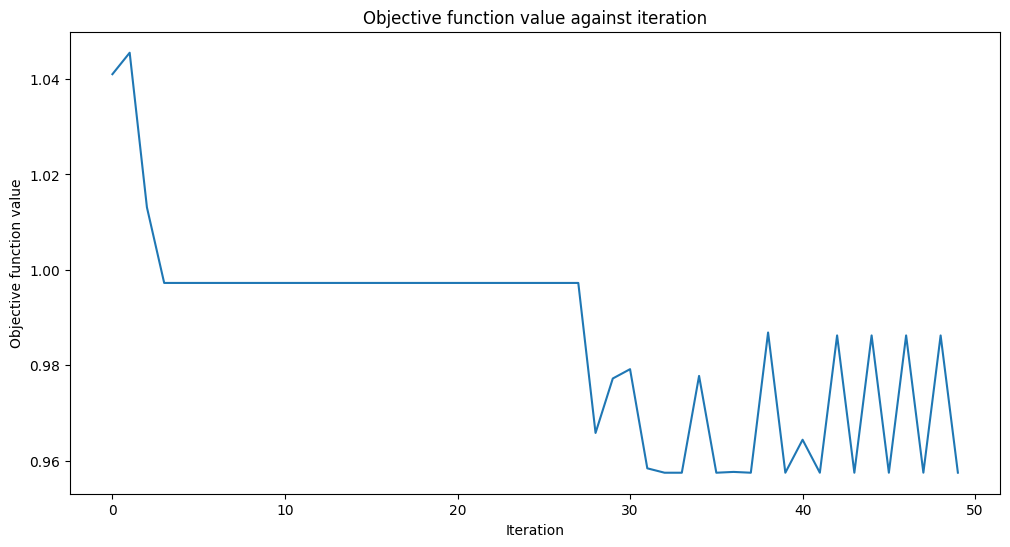

In [19]:
layers_to_test = [1, 2, 3, 4, 5]
training_errors = []
testing_errors = []

#Loop through and test different number of layers
for num_layers in layers_to_test:
    # construct feature map, ansatz, and optimizer
    num_layers = 1
    feature_map = ZZFeatureMap(num_inputs)
    ansatz = double_cnot_rxzx_circuit(num_inputs, num_layers=num_layers)
    initial_point = np.random.rand(num_inputs*num_layers*3)
    
    # construct variational quantum classifier
    vqc = VQC(
        feature_map=feature_map,
        warm_start=True,
        ansatz=ansatz,
        loss="cross_entropy",
        optimizer=COBYLA(maxiter=50),
        callback=callback_graph,
        initial_point=initial_point
    )

    # create empty array for callback to store evaluations of the objective function
    objective_func_vals = []
    plt.rcParams["figure.figsize"] = (12, 6)
    
    # fit classifier to data
    vqc.fit(sample_train, label_train_one_hot)
    
    # return to default figsize
    plt.rcParams["figure.figsize"] = (6, 4)

    # Evaluate the model
    training_error = 1 - vqc.score(sample_train, label_train_one_hot)
    testing_error = 1 - vqc.score(sample_test, label_test_one_hot)
    training_errors.append(training_error)
    testing_errors.append(testing_error)

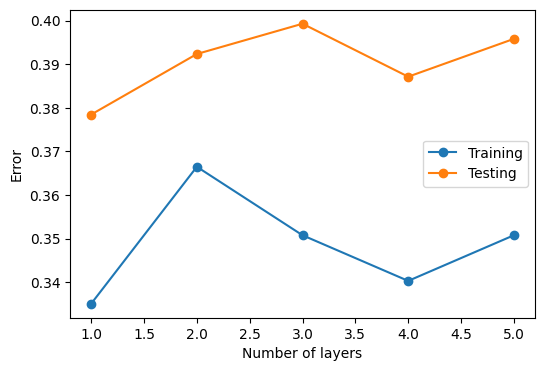

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_xlabel("Number of layers")
ax.set_ylabel("Error")
ax.plot(layers_to_test, training_errors, marker='o', label="Training")
ax.plot(layers_to_test, testing_errors, marker='o', label="Testing")
ax.legend()

## Try CZ entanglement layer
This time instead of CNOT gates, we will use CZ gates for the entanglement layer and then run the same set of tests to see how that impacts performance

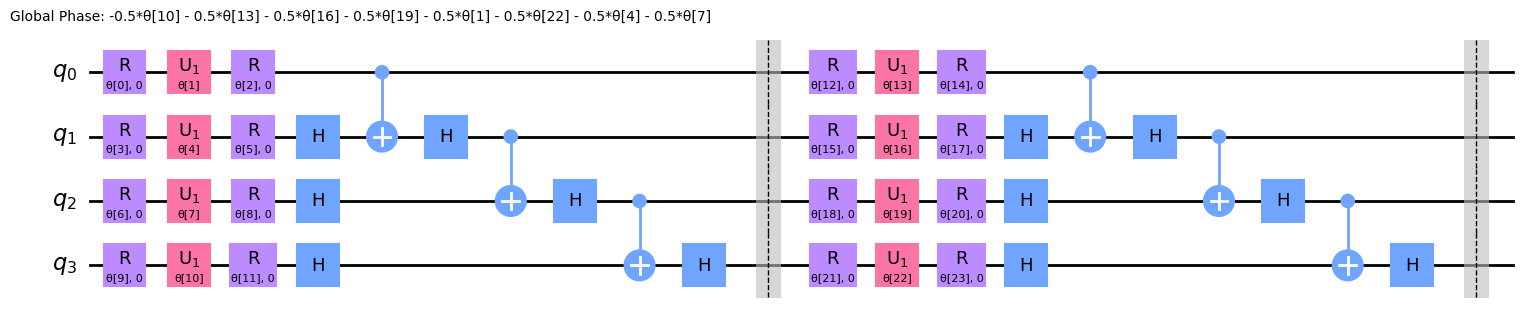

In [21]:
# Create a function so we can easily create new circuits
def cz_rxzx_circuit(num_inputs, num_layers):
    num_parameters = num_inputs * num_layers * 3
    x = ParameterVector("θ", length=num_parameters)
    circuit = QuantumCircuit(num_inputs)
    
    #Create the processing blocks
    for layer in range(num_layers):
        #Create the parameterized gates
        for i in range(num_inputs):
            circuit.rx(x[layer*num_inputs*3 + 3*i], i)
            circuit.rz(x[layer*num_inputs*3 + 3*i + 1], i)
            circuit.rx(x[layer*num_inputs*3 + 3*i + 2], i)
        #Create the entangling layer
        for i in range(num_inputs - 1):
            circuit.cz(i,i+1)
        circuit.barrier()
        
    return circuit

# Draw an example of the ciruit
circuit = cz_rxzx_circuit(4, 2)
circuit.decompose().draw('mpl')

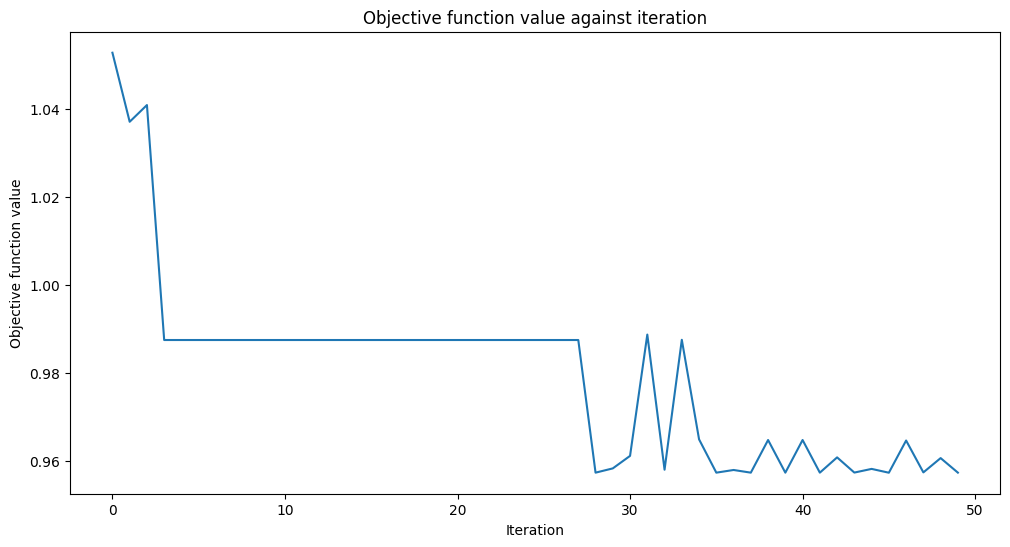

In [22]:
layers_to_test = [1, 2, 3, 4, 5]
training_errors = []
testing_errors = []

#Loop through and test different number of layers
for num_layers in layers_to_test:
    # construct feature map, ansatz, and optimizer
    num_layers = 1
    feature_map = ZZFeatureMap(num_inputs)
    ansatz = cz_rxzx_circuit(num_inputs, num_layers=num_layers)
    initial_point = np.random.rand(num_inputs*num_layers*3)
    
    # construct variational quantum classifier
    vqc = VQC(
        feature_map=feature_map,
        warm_start=True,
        ansatz=ansatz,
        loss="cross_entropy",
        optimizer=COBYLA(maxiter=50),
        callback=callback_graph,
        initial_point=initial_point
    )

    # create empty array for callback to store evaluations of the objective function
    objective_func_vals = []
    plt.rcParams["figure.figsize"] = (12, 6)
    
    # fit classifier to data
    vqc.fit(sample_train, label_train_one_hot)
    
    # return to default figsize
    plt.rcParams["figure.figsize"] = (6, 4)

    # Evaluate the model
    training_error = 1 - vqc.score(sample_train, label_train_one_hot)
    testing_error = 1 - vqc.score(sample_test, label_test_one_hot)
    training_errors.append(training_error)
    testing_errors.append(testing_error)

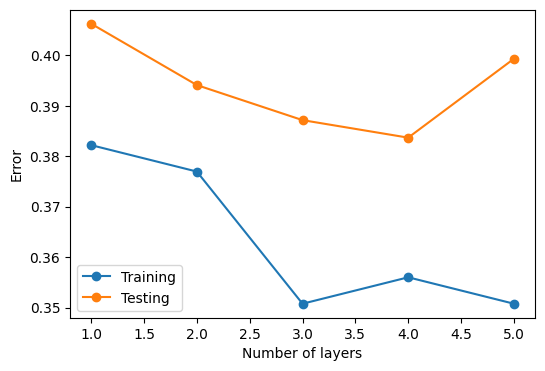

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_xlabel("Number of layers")
ax.set_ylabel("Error")
ax.plot(layers_to_test, training_errors, marker='o', label="Training")
ax.plot(layers_to_test, testing_errors, marker='o', label="Testing")
ax.legend()

### Comments
When varying all of the different types of entanglement layes, we did not see significant difference in the performance. This could be do to several different reasons:
1. We could have too small of a sample size of tests, such that the random fluctuations are larger than the difference in accuracy that we see by varying the entanglement layers
2. We could have trained for an insufficient number of iterations to allow for the larger models to fully converge.
3. One of the other aspects of the model could be the limiting factor to our level of accuracy (e.g. with the ZZfeaturemap we could be limited to a max accuracy of around 62%, therefore we can't see any improvements made by varying the entanglement)
4. Our dataset could be impacting our results. For future tests, we might want to run them on multiple datasets in order to see how the models perform more generally

One thing of note, is that all of the models had a local minimum of testing accuracy at 4 layers. Given the variance in the results and the very small sampling size, this is likely just noise, but it could be something to keep an eye on when running more extensive tests down the line.